In [ ]:
!pip install torch
!pip install torchvision
!pip install diffusers
!pip install tqdm
!pip install einops
!pip install timm
!pip install matplotlib
!pip install accelerate

In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from torchvision.utils import save_image
from IPython.display import Image, display
from download import find_model
from FGFormer.FGFormer import FGFormers
import random
import matplotlib.pyplot as plt

c:\Users\11429\anaconda3\envs\transformers\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(0)
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [4]:
model = FGFormers["FGFormer-B/4"](
        input_size=32,
        num_classes=14
).to(device)
ckpt_path = "0090000.pt"
state_dict = find_model(ckpt_path)
model.load_state_dict(state_dict)
model.eval()
diffusion = create_diffusion(str(1000))
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-mse").to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [5]:
class_labels = [random.randint(0, 14 - 1) for _ in range(8)]
n = len(class_labels)
z = torch.randn(n, 4, 32, 32, device=device)
y = torch.tensor(class_labels, device=device)

In [6]:
z = torch.cat([z, z], 0)
y_null = torch.tensor([14] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=4.0)

In [7]:
# I recommend running this on a GPU, but it works on a CPU too
# GPU will cost less than 1 minute, CPU will cost about 12 minutes
samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
    )
samples, _ = samples.chunk(2, dim=0)
samples = vae.decode(samples / 0.18215).sample

100%|██████████| 1000/1000 [12:33<00:00,  1.33it/s]


In [8]:

save_image(samples, "sample.png", nrow=4, normalize=True, value_range=(-1, 1))

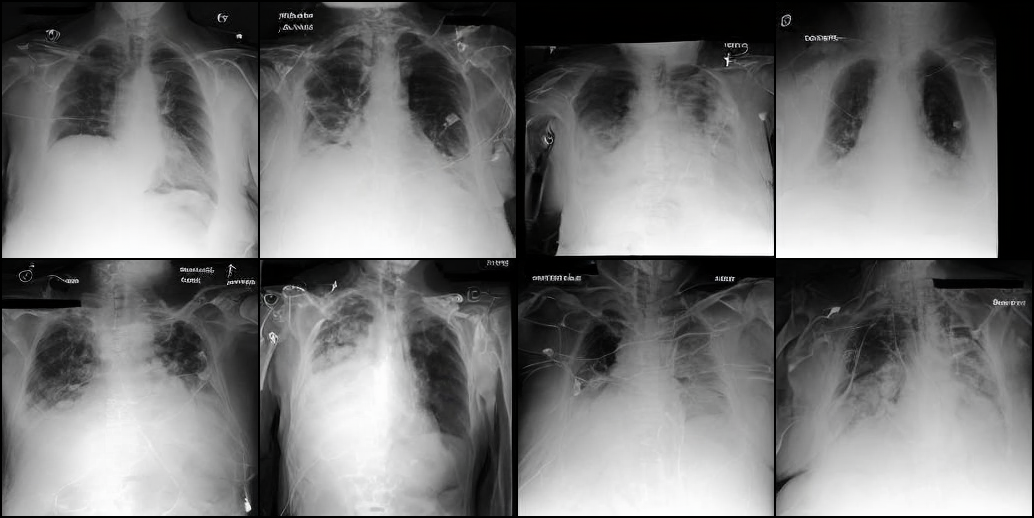

In [9]:
display(Image(filename='sample.png'))